In [11]:
from optparse import OptionParser
import subprocess
import array
from  array import array
import numpy as np
import json

import ROOT
from ROOT import TGraph, TLatex, TFile, TLine, TLegend, TCanvas, kOrange, kGreen, kTRUE, gStyle, gROOT

import header
from header import WaitForJobs, make_smooth_graph, Inter
import tdrstyle, CMS_lumi

gStyle.SetOptStat(0)
gROOT.SetBatch(kTRUE)



Welcome to JupyROOT 6.14/09


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/lcg/root/6.14.09-pafccj5/lib/ROOT.py:577: UserWarning: "from ROOT import *" is not supported under IPython
  warnings.warn( '"from ROOT import *" is not supported under IPython' )


In [6]:
year = '2017'
signal = 'rsgluon'
# signal = 'zprime10'
# signal = 'zprime30'
# signal = 'zprimeDM'


cats = [
    'cen0b_0x1',
    'fwd0b_0x1',
    'cen1b_3x1',
    'fwd1b_3x1',
    'cen2b_3x1',
    'fwd2b_3x1',
]


In [7]:
# parser = OptionParser()

# # parser.add_option('-t', '--tag', metavar='FILE', type='string', action='store',
# #                 default   =   'dataBsOff',
# #                 dest      =   'tag',
# #                 help      =   'Tag ran over')
# parser.add_option('-s', '--signals', metavar='FILE', type='string', action='store',
#                 default   =   'bstar_signalsLH.txt',
#                 dest      =   'signals',
#                 help      =   'Text file containing the signal names and their corresponding cross sections')
# parser.add_option('-P', '--plotOnly', action="store_true",
#                 default   =   False,
#                 dest      =   'plotOnly',
#                 help      =   'Only plots if True')
# parser.add_option('--unblind', action="store_false",
#                 default   =   True,
#                 dest      =   'blind',
#                 help      =   'Only plot observed limit if false')
# parser.add_option('--drawIntersection', action="store_true",
#                 default   =   False,
#                 dest      =   'drawIntersection',
#                 help      =   'Draw intersection values')
# parser.add_option('-l', '--lumi', metavar='F', type='string', action='store',
#                 default       =       '35.9',
#                 dest          =       'lumi',
#                 help          =       'Luminosity option')
# parser.add_option('-m', '--mod', metavar='F', type='string', action='store',
#                 default       =       '',
#                 dest          =       'mod',
#                 help          =       'Modification to limit title on y-axis. For example, different handedness of the signal')

# (options, args) = parser.parse_args()



In [8]:
drawIntersection = False
blind = False

In [12]:
signal_df = json.load(open('signal_xs.json'))

In [13]:
# tag = options.tag
# Open signal file


period = 1
if '2018' in year:
    period = 18
    lumi = '60'
elif '2017' in year:
    period = 17
    lumi = '41.5'
elif '2016' in year:
    period = 16
    lumi = '35.9'

signal_string = "g_{KK}"
legend_string = ""

if 'zprime' in signal:
    signal_string = "Z'"
    
    if 'DM' in signal:
        signal_string = "Z'_{DM}"
    elif '10' in signal:
        legend_string = "10% Width"
    elif '30' in signal:
        legend_string = "30% Width"
    


In [24]:

# directory where signal directories are located
directory = 'regions/'+year+'/ttbarfits_inclusive'
print directory
signame = 'signalRSGluon'

tag = ''
if 'zprime' in signal: 
    signame = 'signalZPrime'
    if 'DM' in signal:
        tag = '_DM'
    elif '10' in signal:
        legend_string = "10% Width"
        tag = '_10'
    elif '30' in signal:
        tag = '_30'


signal_mass  = signal_df[signal]['mass']
signal_names = [directory + '/' + signame + str(int(s*1000)) + tag + '_area' for s in signal_mass]
theory_xsecs = signal_df[signal]['theory']
signal_xsecs = signal_df[signal]['expected']

regions/2017/ttbarfits_cen2b_3x1


In [25]:
signal_names

['regions/2017/ttbarfits_cen2b_3x1/signalRSGluon1000_area',
 'regions/2017/ttbarfits_cen2b_3x1/signalRSGluon1500_area',
 'regions/2017/ttbarfits_cen2b_3x1/signalRSGluon2000_area',
 'regions/2017/ttbarfits_cen2b_3x1/signalRSGluon2500_area',
 'regions/2017/ttbarfits_cen2b_3x1/signalRSGluon3000_area',
 'regions/2017/ttbarfits_cen2b_3x1/signalRSGluon3500_area']

In [26]:
# Initialize arrays to eventually store the points on the TGraph
x_mass = array('d')
y_limit = array('d')
y_mclimit  = array('d')
y_mclimitlow68 = array('d')
y_mclimitup68 = array('d')
y_mclimitlow95 = array('d')
y_mclimitup95 = array('d')


In [27]:

tdrstyle.setTDRStyle()


# For each signal
for this_index, this_name in enumerate(signal_names):
    # Setup call for one of the signal
    this_xsec = signal_xsecs[this_index]
    this_mass = signal_mass[this_index]
    this_output = TFile.Open(this_name+'/higgsCombineTest.AsymptoticLimits.mH120.root')
    if not this_output: continue
    this_tree = this_output.Get('limit')
    
    this_xsec = this_xsec
    
    
    # Set the mass (x axis)
    x_mass.append(this_mass)
    # Grab the cross section limits (y axis)
    for ievent in range(int(this_tree.GetEntries())):
        this_tree.GetEntry(ievent)
        
        
        
        # Nominal expected
        if this_tree.quantileExpected == 0.5:
            y_mclimit.append(this_tree.limit*this_xsec)
        # -1 sigma expected
        if round(this_tree.quantileExpected,2) == 0.16:
            y_mclimitlow68.append(this_tree.limit*this_xsec)
        # +1 sigma expected
        if round(this_tree.quantileExpected,2) == 0.84:
            y_mclimitup68.append(this_tree.limit*this_xsec)
        # -2 sigma expected
        if round(this_tree.quantileExpected,3) == 0.025:
            y_mclimitlow95.append(this_tree.limit*this_xsec)
        # +2 sigma expected
        if round(this_tree.quantileExpected,3) == 0.975:
            y_mclimitup95.append(this_tree.limit*this_xsec)

        # Observed (plot only if unblinded)
        if this_tree.quantileExpected == -1: 
            if not blind:
                print('DEBUG : appending to y_limit')
                print('appending: {} to y_limit'.format(this_tree.limit*this_xsec))
                y_limit.append(this_tree.limit*this_xsec)
            else:
                y_limit.append(0.0)
    

In [28]:


# Make Canvas and TGraphs (mostly stolen from other code that formats well)
climits = TCanvas("climits", "climits",700, 600)
climits.SetLogy(True)
climits.SetLeftMargin(.15)
climits.SetBottomMargin(.15)  
climits.SetTopMargin(0.1)
climits.SetRightMargin(0.05)


# Expected
print('---------DEBUG-----------')
print('x_mass: {}'.format(x_mass))
print('len x_mass: {}'.format(len(x_mass)))
print('y_mclimit: {}'.format(y_mclimit))
g_mclimit = TGraph(len(x_mass), x_mass, y_mclimit)
g_mclimit.SetTitle("")
g_mclimit.SetMarkerStyle(21)
g_mclimit.SetMarkerColor(1)
g_mclimit.SetLineColor(1)
g_mclimit.SetLineStyle(2)
g_mclimit.SetLineWidth(3)
g_mclimit.SetMarkerSize(0.)


ymax = 1e4
xmin = signal_mass[0]
xmax = signal_mass[-1]


linestyle = "l"
fillstyle = "lf"

blind=True
# Observed
if not blind:
    print 'Not blinded'
    print('---------------DEBUG---------------------')
    print('x_mass: {}'.format(x_mass))
    print('len x_mass: {}'.format(len(x_mass)))
    print('y_limit: {}'.format(y_limit))
    g_limit = TGraph(len(x_mass), x_mass, y_limit)
    g_limit.SetTitle("")
    g_limit.SetMarkerStyle(7)
    g_limit.SetMarkerColor(1)
    g_limit.SetLineColor(1)
    g_limit.SetLineWidth(2)
    g_limit.SetMarkerSize(1) #0.5
    g_limit.GetYaxis().SetRangeUser(0., 80.)
    g_limit.GetXaxis().SetRangeUser(xmin, xmax)
    g_limit.SetMinimum(0.3e-2) #0.005
    g_limit.SetMaximum(ymax)
else:
    print 'Blinded'
    g_mclimit.GetXaxis().SetTitle("m_{"+signal_string+" [TeV]")  # NOT GENERIC
    g_mclimit.GetYaxis().SetTitle("#sigma_{"+signal_string+" #times B("+signal_string+" #rightarrow t #bar{t}) [pb]") # NOT GENERIC
    g_mclimit.GetYaxis().SetRangeUser(0., 80.)
    g_mclimit.GetXaxis().SetRangeUser(xmin, xmax)
    g_mclimit.SetMinimum(0.3e-2) #0.005
    g_mclimit.SetMaximum(ymax)  
    

# Will later be 1 and 2 sigma expected
g_mcplus = TGraph(len(x_mass), x_mass, y_mclimitup68)
g_mcminus = TGraph(len(x_mass), x_mass, y_mclimitlow68)

g_mc2plus = TGraph(len(x_mass), x_mass, y_mclimitup95)
g_mc2minus = TGraph(len(x_mass), x_mass, y_mclimitlow95)


# Theory line
graphWP = ROOT.TGraph()
graphWP.SetTitle("")
graphWP.SetMarkerStyle(23)
graphWP.SetMarkerColor(4)
graphWP.SetMarkerSize(0.5)
graphWP.GetYaxis().SetRangeUser(0., 80.)
graphWP.GetXaxis().SetRangeUser(xmin, xmax)
graphWP.SetMinimum(0.3e-2) #0.005
graphWP.SetMaximum(ymax)
for index,mass in enumerate(signal_mass):
    xsec = theory_xsecs[index]
    graphWP.SetPoint(index,    mass,   xsec    )

graphWP.SetLineWidth(3)
graphWP.SetLineColor(4)

# 2 sigma expected
g_error95 = make_smooth_graph(g_mc2minus, g_mc2plus)
g_error95.SetFillColor(kOrange)
g_error95.SetLineColor(0)

# 1 sigma expected
g_error = make_smooth_graph(g_mcminus, g_mcplus)
g_error.SetFillColor( kGreen+1)
g_error.SetLineColor(0)

# Finally calculate the intercept
expectedMassLimit, expectedCrossLimit = Inter(g_mclimit,graphWP) #if len(Inter(g_mclimit,graphWP)) > 0 else -1.0
upLimit,trash = Inter(g_mcminus,graphWP) if len(Inter(g_mcminus,graphWP)) > 0 else -1.0
lowLimit,trash = Inter(g_mcplus,graphWP) if len(Inter(g_mcplus,graphWP)) > 0 else -1.0

print 'expectedMassLimit', expectedMassLimit
print 'expectedCrossLimit', expectedCrossLimit

if not blind:
    g_limit.GetXaxis().SetTitle("m_{"+signal_string+"} [TeV]")  # NOT GENERIC
    g_limit.GetYaxis().SetTitle("#sigma_{"+signal_string+"} #times B("+signal_string+" #rightarrow t #bar{t}) [pb]") # NOT GENERIC
    g_limit.GetXaxis().SetTitleSize(0.055)
    g_limit.GetYaxis().SetTitleSize(0.05)
    g_limit.Draw('ap')
    g_error95.Draw(fillstyle)
    g_error.Draw(fillstyle)
    g_mclimit.Draw("ap")
    g_limit.Draw("ap")

    graphWP.Draw(linestyle)
    g_limit.GetYaxis().SetTitleOffset(1.5)
    g_limit.GetXaxis().SetTitleOffset(1.25)

else:
    g_mclimit.GetXaxis().SetTitle("m_{"+signal_string+"} [TeV]")  # NOT GENERIC
    g_mclimit.GetYaxis().SetTitle("#sigma_{"+signal_string+"} #times B("+signal_string+" #rightarrow t #bar{t}) [pb]") # NOT GENERIC
    g_mclimit.GetXaxis().SetTitleSize(0.055)
    g_mclimit.GetYaxis().SetTitleSize(0.05)
    g_mclimit.Draw("ap")
    g_error95.Draw(fillstyle)
    g_error.Draw(fillstyle)
    g_mclimit.Draw(linestyle)
    graphWP.Draw(linestyle)
    g_mclimit.GetYaxis().SetTitleOffset(1.5)
    g_mclimit.GetXaxis().SetTitleOffset(1.25)
    
# graphWP.Draw("c")







if drawIntersection:
    expLineLabel = TPaveText(expectedMassLimit-300, expectedCrossLimit*2, expectedMassLimit+300, expectedCrossLimit*15, "NB")
    expLineLabel.SetFillColorAlpha(kWhite,0)
    expLineLabel.AddText(str(int(expectedMassLimit))+' TeV')
    expLineLabel.Draw()

print 'Expected limit: '+str(expectedMassLimit) + ' +'+str(upLimit-expectedMassLimit) +' -'+str(expectedMassLimit-lowLimit) + ' TeV' # NOT GENERIC
if not blind:
    obsMassLimit,obsCrossLimit = Inter(g_limit,graphWP) if len(Inter(g_limit,graphWP)) > 0 else -1.0
    print 'Observed limit: '+str(obsMassLimit) + ' TeV'

    obsLine = TLine(obsMassLimit,g_mclimit.GetMinimum(),obsMassLimit,obsCrossLimit)
    obsLine.SetLineStyle(2)
    obsLine.Draw()

    if drawIntersection:
        obsLineLabel = TPaveText(obsMassLimit-300, obsCrossLimit*3, obsMassLimit+300, obsCrossLimit*12,"NB")
        obsLineLabel.SetFillColorAlpha(kWhite,0)
        obsLineLabel.AddText(str(int(obsMassLimit))+' TeV')
        obsLineLabel.Draw()

        
        
        
# Legend and draw



gStyle.SetLegendFont(42)
legend = TLegend(0.60, 0.60, 0.91, 0.87, '')
legend.SetHeader("95% CL upper limits")
if not blind:
    legend.AddEntry(g_limit, "Observed", "l")
legend.AddEntry(g_mclimit, "Median expected","l")
legend.AddEntry(g_error, "68% expected", "f")
legend.AddEntry(g_error95, "95% expected", "f")
legend.AddEntry(graphWP, "Theory "+signal_string+" "+legend_string, "l")   # NOT GENERIC

legend.SetBorderSize(0)
legend.SetFillStyle(0)
legend.SetLineColor(0)

legend.Draw("same")


climits.RedrawAxis()

CMS_lumi.extraText = 'Preliminary'
CMS_lumi.lumiTextSize     = 0.4
CMS_lumi.cmsTextSize      = 0.5

CMS_lumi.CMS_lumi(climits, period, 11)


savefilename = 'limits/pdf/limits_combine_' + signal + '_' + year + '.pdf'

climits.SaveAs(savefilename)
climits.SaveAs(savefilename.replace('pdf', 'png'))
print 'saving ' + savefilename
print 'saving ' + savefilename.replace('pdf', 'png')







---------DEBUG-----------
x_mass: array('d', [1.0, 1.5, 2.0, 2.5, 3.0, 3.5])
len x_mass: 6
y_mclimit: array('d', [16.3475390625, 0.8890078125, 0.246460546875, 0.11307216796875, 0.0706431640625, 0.056196875])
Blinded
expectedMassLimit 3.5895
expectedCrossLimit 0.0534073051953
Expected limit: 3.5895 +0.108 -2.58 TeV
saving limits/pdf/limits_combine_rsgluon_2017.pdf
saving limits/png/limits_combine_rsgluon_2017.png


Warning in <TCanvas::Constructor>: Deleting canvas with same name: climits
Info in <TCanvas::Print>: pdf file limits/pdf/limits_combine_rsgluon_2017.pdf has been created
Info in <TCanvas::Print>: png file limits/png/limits_combine_rsgluon_2017.png has been created


In [29]:
# del climits 

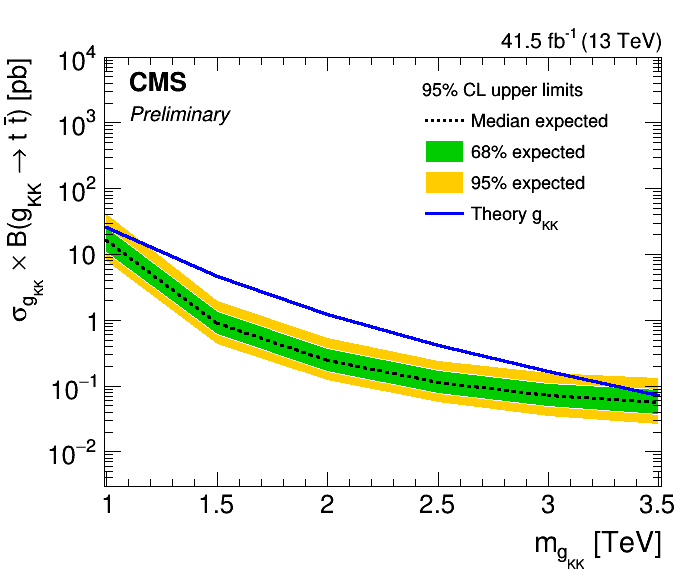

In [30]:
climits.Draw()

In [5]:
np.arange(800, 6800, 300)

array([ 800, 1100, 1400, 1700, 2000, 2300, 2600, 2900, 3200, 3500, 3800,
       4100, 4400, 4700, 5000, 5300, 5600, 5900, 6200, 6500])

In [2]:
import numpy as np